Data Mining project  
AY 2022/23  
Task 4  
Group 12  
Leonardo Vona  
545042  

January 8. 2023

#**Time series analysis**

In [ ]:
!pip install tslearn
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf

from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from tsfresh import extract_relevant_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.cluster import KMeans
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import normalized_mutual_info_score

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


Read the tweets and users data frames.

In [ ]:
tweets_df = pd.read_csv('./tweets_edited.csv', sep=',', index_col=0, lineterminator='\n')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
users_df = pd.read_csv('./users_edited.csv', sep=',')

## **Preprocessing**

Apply the correct type for the variables of interest in the time series analysis.

In [ ]:
tweets_df['user_id'] = tweets_df['user_id'].apply(str)
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], infer_datetime_format=True, errors='coerce')

In [ ]:
users_df['id'] = users_df['id'].apply(str)
users_df['bot'] = users_df['bot'].apply(str)

Take only the tweets published in 2019.

In [ ]:
tweets_df = tweets_df[tweets_df['created_at'].dt.year == 2019]

Filter the tweets belonging to a user also listed in the users data set.

In [ ]:
tweets_df = tweets_df[tweets_df['user_id'].isin(users_df['id'])]

Compute the Success score of a tweet by means of the Acceptance and Diffusion scores.

In [ ]:
def acceptanceScore(day):
  return day['retweet_count'] + day['reply_count'] + day['favorite_count']

def diffusionScore(day):
  return day['num_hashtags'] + day['num_mentions'] + day['num_urls']

def successScore(day):
  return acceptanceScore(day) / (diffusionScore(day) + 0.1)

For each user compute the Success score for each day of 2019 where she / he has published at least a tweet.

In [ ]:
successScores = tweets_df.groupby(['user_id', tweets_df['created_at'].dt.date]).sum().agg(successScore, axis="columns")

In [ ]:
successScores

user_id    created_at
100043740  2019-04-10     5.853659
           2019-04-11    30.000000
           2019-04-12    27.272727
           2019-04-13     5.121951
           2019-04-14    30.000000
                           ...    
999662546  2019-07-26     0.952381
           2019-07-28     3.636364
           2019-07-31     0.909091
           2019-08-01     0.909091
           2019-08-02     0.909091
Length: 501659, dtype: float64

For each user fill the missing days of the time series with the value -1.

In [ ]:
(user_id_index, created_at_index) = successScores.index.levels

new_index = pd.MultiIndex.from_product([user_id_index, pd.date_range('01-01-2019', '12-31-2019')])

successScores = successScores.reindex(new_index).fillna(-1).astype(float)

successScores

user_id              
100043740  2019-01-01   -1.0
           2019-01-02   -1.0
           2019-01-03   -1.0
           2019-01-04   -1.0
           2019-01-05   -1.0
                        ... 
999662546  2019-12-27   -1.0
           2019-12-28   -1.0
           2019-12-29   -1.0
           2019-12-30   -1.0
           2019-12-31   -1.0
Length: 2473970, dtype: float64

The following is an example success score time series for the year 2019.

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(successScores['100043740'])

2019-01-01     -1.000000
2019-01-02     -1.000000
2019-01-03     -1.000000
2019-01-04     -1.000000
2019-01-05     -1.000000
2019-01-06     -1.000000
2019-01-07     -1.000000
2019-01-08     -1.000000
2019-01-09     -1.000000
2019-01-10     -1.000000
2019-01-11     -1.000000
2019-01-12     -1.000000
2019-01-13     -1.000000
2019-01-14     -1.000000
2019-01-15     -1.000000
2019-01-16     -1.000000
2019-01-17     -1.000000
2019-01-18     -1.000000
2019-01-19     -1.000000
2019-01-20     -1.000000
2019-01-21     -1.000000
2019-01-22     -1.000000
2019-01-23     -1.000000
2019-01-24     -1.000000
2019-01-25     -1.000000
2019-01-26     -1.000000
2019-01-27     -1.000000
2019-01-28     -1.000000
2019-01-29     -1.000000
2019-01-30     -1.000000
2019-01-31     -1.000000
2019-02-01     -1.000000
2019-02-02     -1.000000
2019-02-03     -1.000000
2019-02-04     -1.000000
2019-02-05     -1.000000
2019-02-06     -1.000000
2019-02-07     -1.000000
2019-02-08     -1.000000
2019-02-09     -1.000000


Plot two example time series.

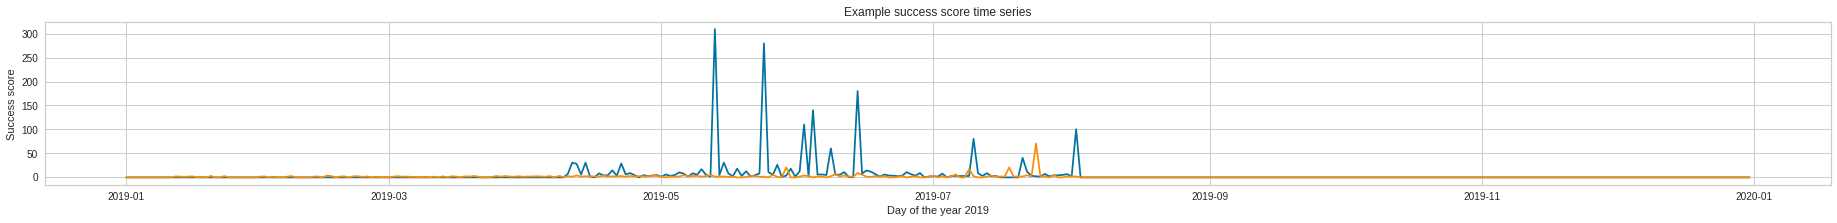

In [ ]:
plt.figure(figsize=(32,3))
plt.title("Example success score time series")
plt.xlabel("Day of the year 2019")
plt.ylabel("Success score")
plt.plot(successScores.get('100043740'))
plt.plot(successScores.get('999662546'), color='darkorange')
plt.show()

### **Amplitude scaling**

Transform the time series to remove distortion due to different amplitudes.

In [ ]:
successScores = successScores.groupby('user_id').apply(lambda ts: (ts - ts.mean())/ts.std())

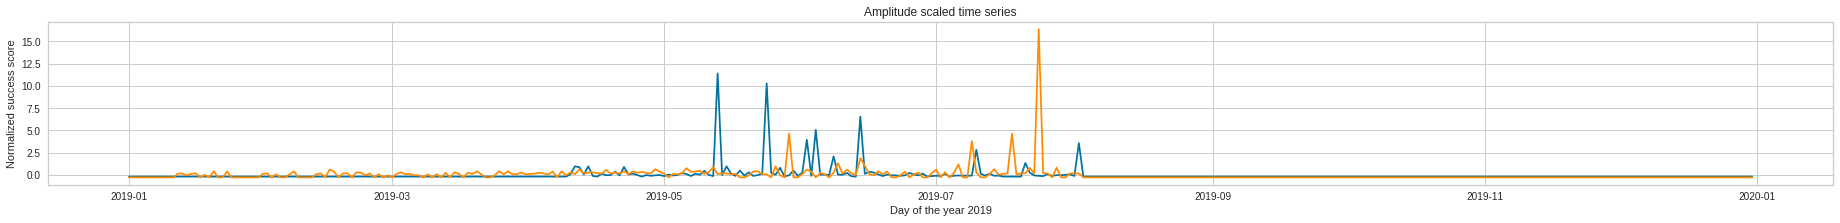

In [ ]:
plt.figure(figsize=(32,3))
plt.title("Amplitude scaled time series")
plt.xlabel("Day of the year 2019")
plt.ylabel("Normalized success score")
plt.plot(successScores.get('100043740'))
plt.plot(successScores.get('999662546'), color='darkorange')
plt.show()

## **Clustering**

Two types of clusterings are performed over the time series:
- partitional clustering, using TimeSeriesKMeans to group similar time series based on their Dynamic Type Warping distance
- feature-based clustering, extracting relevant features from the time series and using them to produce the clustering

The time series are converted to a suitable format for the clustering.

In [ ]:
X = successScores.unstack().values[:, :]

In [ ]:
X

array([[-0.20495267, -0.20495267, -0.20495267, ..., -0.20495267,
        -0.20495267, -0.20495267],
       [-0.41990284, -0.41990284, -0.41990284, ..., -0.41990284,
        -0.41990284, -0.41990284],
       [-0.29234245, -0.29234245, -0.29234245, ..., -0.29234245,
        -0.29234245, -0.29234245],
       ...,
       [-0.26910144, -0.26910144, -0.15467175, ..., -0.26910144,
        -0.26910144, -0.26910144],
       [-0.31917234, -0.31917234, -0.25788945, ..., -0.31917234,
        -0.31917234, -0.31917234],
       [-0.29461957, -0.29461957, -0.29461957, ..., -0.29461957,
        -0.29461957, -0.29461957]])

The bot labels of the users are extracted and stored ordered by user id.

In [ ]:
y = users_df[users_df['id'].isin(tweets_df['user_id'].unique())].sort_values(by='id')['bot'].values

In [ ]:
y

array(['0', '1', '0', ..., '0', '0', '0'], dtype=object)

### **Partitional clustering**

To determine the most suitable value for the best K in TimeSeriesKMeans, I use the elbow and silhouette analysis.

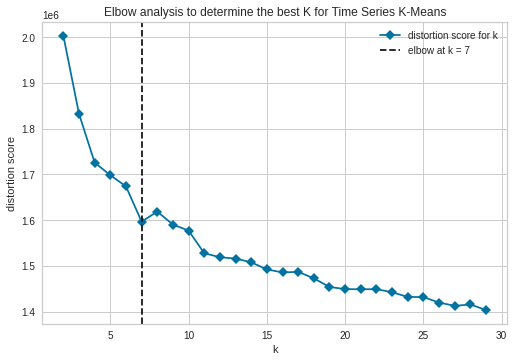

In [ ]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(TimeSeriesKMeans(), 
                       k=(k_min, k_max), 
                       metric='distortion', 
                       timings=False, 
                       size=(600,400))
vis.fit(X)  
vis.ax.set_ylabel('distortion score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Elbow analysis to determine the best K for Time Series K-Means')
plt.legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_)])

plt.show()

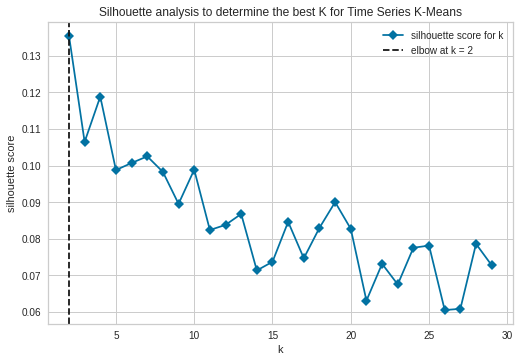

In [ ]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(TimeSeriesKMeans(), 
                       k=(k_min, k_max), 
                       metric='silhouette', 
                       timings=False, 
                       size=(600,400))
vis.fit(X)  
vis.ax.set_ylabel('silhouette score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Silhouette analysis to determine the best K for Time Series K-Means')
plt.legend(['silhouette score for k','elbow at k = ' + str(vis.elbow_value_)])

plt.show()

From the analysis (and after experiments), the number of clusters has been set to 5.

In [ ]:
km = TimeSeriesKMeans(
    n_clusters=5, 
    metric="dtw", 
    max_iter=3,
    max_iter_barycenter = 3,
    metric_params = {
        'global_constraint': 'itakura'
        },
    random_state=42,
    n_jobs = -1)

km.fit(X)

TimeSeriesKMeans(max_iter=3, max_iter_barycenter=3, metric='dtw',
                 metric_params={'global_constraint': 'itakura'}, n_clusters=5,
                 n_jobs=-1, random_state=42)

The clustering has a very good value for the SSE.

In [ ]:
print("SSE: {}".format(km.inertia_))

SSE: 78.90281565647388


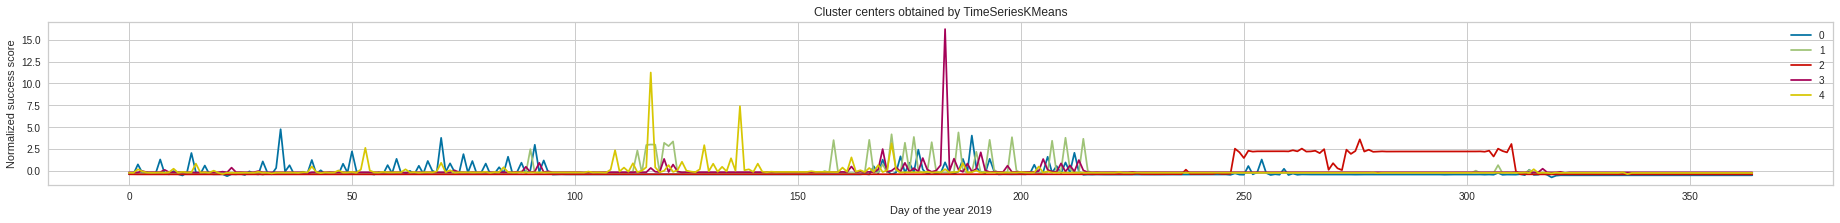

In [ ]:
plt.figure(figsize=(32,3))
plt.title("Cluster centers obtained by TimeSeriesKMeans")
plt.xlabel("Day of the year 2019")
plt.ylabel("Normalized success score")
for i in range(5):
  plt.plot(km.cluster_centers_[i,:,0])
plt.legend(range(5))
plt.show()

Comparing the cluster centers time series we can see that:
- the users into cluster 0 have an oscillating success score for the first three months of the year and in June; for the rest of the year the score is limited and stable
- the users into cluster 1 have a limited activity for the whole year, with some small peaks between May and July
- the users into cluster 2 have a stable and very low value of success score up to August, and then their tweets become trending for 2 / 3 months
- the users into cluster 3 have a very high peak by the end of June and the beginning of July, and the rest of 2019 is quite stable
- the users into cluster 4 have a small success score for the majority of the year, except for April where there are some significant peaks.

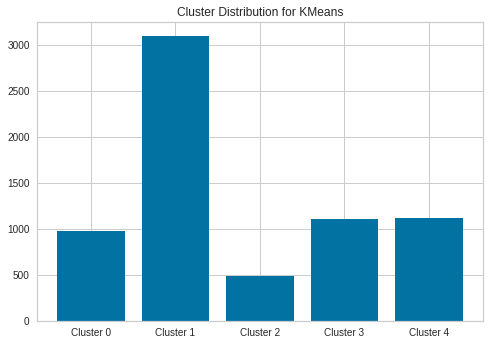

In [ ]:
cluster_c = [len(km.labels_[km.labels_==i]) for i in range(5)]
cluster_n = ["Cluster "+str(i) for i in range(5)]
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

The users are quite evenly distributed across the clusters, except cluster 1 which contains an higher number of users.

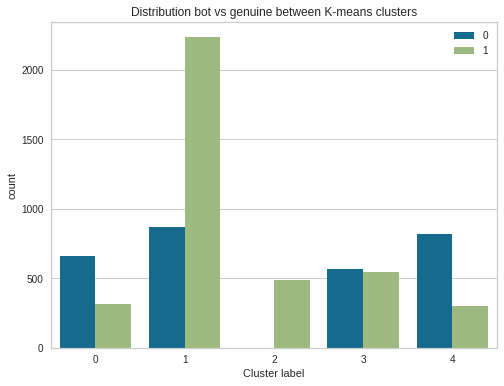

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) 

sn.countplot(x=km.labels_, hue=y)
plt.title('Distribution bot vs genuine between K-means clusters')
plt.xlabel('Cluster label')

plt.show()

By plotting the distribution of users between the clusters with respect to the class label, it is interesting to see that:
- cluster 2 contains almost no genuine users
- cluster 0 and 4 have more than double of genuine users with respect to bots
- in cluster 1 the number of bots is almost three times the number of genuine users

From the external metrics reported below we can see that the clustering has a relatively good value of homogeneity with respect to the 'bot' feature.

In [ ]:
kmeans_eval_df = pd.DataFrame()

kmeans_eval_df['Feature'] = ['bot']
kmeans_eval_df['Similarity'] = adjusted_rand_score(y, km.labels_)
kmeans_eval_df['Homogeneity'] = homogeneity_score(y, km.labels_)
kmeans_eval_df['Completeness'] = completeness_score(y, km.labels_)
kmeans_eval_df['Mutual Information'] = normalized_mutual_info_score(y, km.labels_, average_method='arithmetic')

kmeans_eval_df.set_index(['Feature'], inplace=True)

kmeans_eval_df

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
bot,0.095421,0.163539,0.07875,0.106308


### **Feature-based clustering**

The relevant features are computed using tsfresh. First the relevant features are extracted from the time series using 'extract_relevant_features', then the relevance table is calculated, and the 11 most relevant features are chosen to be used for the clustering.

In [ ]:
successScores_df = successScores.reset_index(level=[0,1])
successScores_df = successScores_df.rename(columns={'level_1': 'day', 0: 'success_score'})
y_series = pd.Series(y.tolist(),index=sorted(successScores_df['user_id'].unique()))

In [ ]:
features_filtered_direct = extract_relevant_features(successScores_df, y_series,
                                                     column_id='user_id', column_sort='day')
relevance_table = calculate_relevance_table(features_filtered_direct, y_series)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)

Feature Extraction: 100%|██████████| 6778/6778 [26:28<00:00,  4.27it/s]


In [ ]:
F = features_filtered_direct[relevance_table['feature'][:11]]

As for TimeSeriesKMeans, the best K is determined using the elbow and silhouette method.

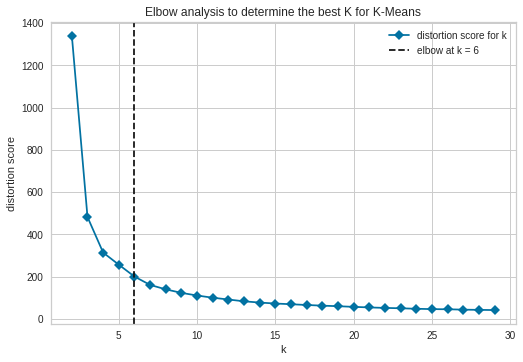

In [ ]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(KMeans(), 
                       k=(k_min, k_max), 
                       metric='distortion', 
                       timings=False, 
                       size=(600,400))
vis.fit(np.array(F))  
vis.ax.set_ylabel('distortion score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Elbow analysis to determine the best K for K-Means')
plt.legend(['distortion score for k','elbow at k = ' + str(vis.elbow_value_)])

plt.show()

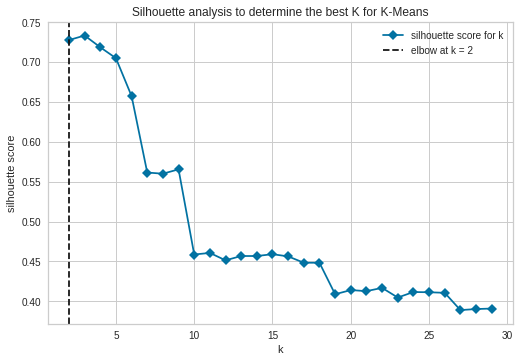

In [ ]:
k_min = 2
k_max = 30

vis = KElbowVisualizer(KMeans(), 
                       k=(k_min, k_max), 
                       metric='silhouette', 
                       timings=False, 
                       size=(600,400))
vis.fit(np.array(F))  
vis.ax.set_ylabel('silhouette score')
vis.ax.set_xlabel('k')
vis.ax.set_title('Silhouette analysis to determine the best K for K-Means')
plt.legend(['silhouette score for k','elbow at k = ' + str(vis.elbow_value_)])

plt.show()

From the plots it seems that 3 could be a good value for K.

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(n_clusters=3)

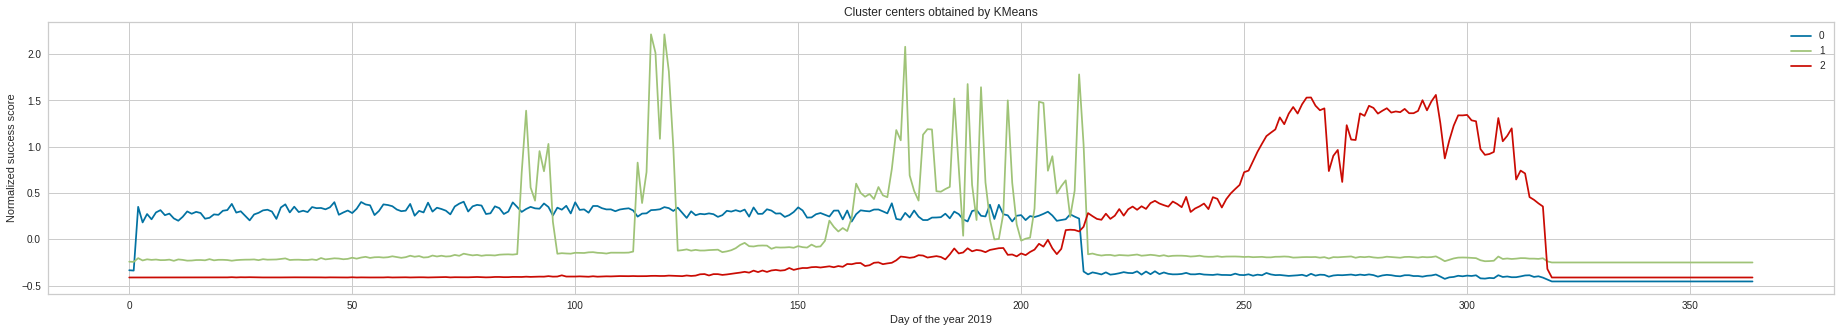

In [ ]:
plt.figure(figsize=(32,5))
plt.title("Cluster centers obtained by KMeans")
plt.xlabel("Day of the year 2019")
plt.ylabel("Normalized success score")
for i in range(3):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.legend(range(3))
plt.show()

From the plot above we can see the mean behavior of users for each of the three clusters identified:
- cluster 0 groups users with a limited and stable Success score towards the year
- cluster 1 identifies users having multiple peaks of Success score, especially up to July
- cluster 2 represents users with a limited Success score up to August, then the tendency changes, gaining a high Success for a couple of months, probably because the topic of their tweets was trending for that period of 2019

The SSE is quite higher if compared to the other clustering technique user.

In [ ]:
print("SSE: {}".format(kmeans.inertia_))

SSE: 482.14515292050794


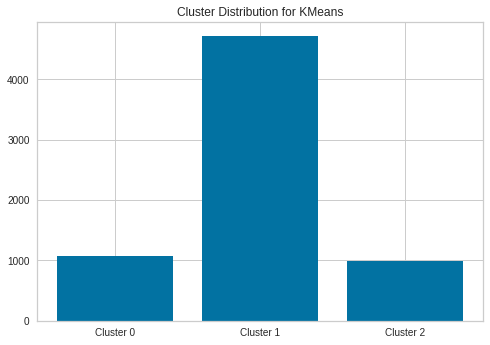

In [ ]:
cluster_c = [len(kmeans.labels_[kmeans.labels_==i]) for i in range(3)]
cluster_n = ["Cluster "+str(i) for i in range(3)]
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

The population is unbalanced towards cluster 1, which contains most of the users.

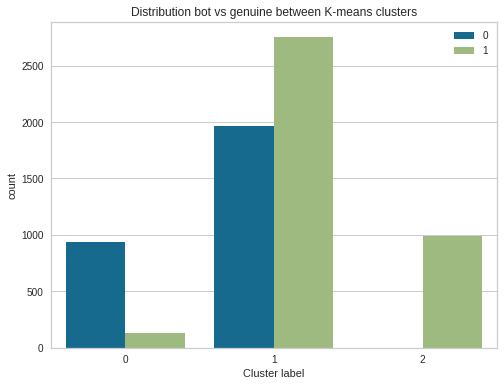

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) 

sn.countplot(x=kmeans.labels_, hue=y)
plt.title('Distribution bot vs genuine between K-means clusters')
plt.xlabel('Cluster label')

plt.show()

The cluster 2, which has a similar tendency of cluster 2 from the partitional clustering, only contains bot users. On the other hand, cluster 0 contains genuine users for the vast majority.

In [ ]:
kmeans_eval_df = pd.DataFrame()

kmeans_eval_df['Feature'] = ['bot']
kmeans_eval_df['Similarity'] = adjusted_rand_score(y, kmeans.labels_)
kmeans_eval_df['Homogeneity'] = homogeneity_score(y, kmeans.labels_)
kmeans_eval_df['Completeness'] = completeness_score(y, kmeans.labels_)
kmeans_eval_df['Mutual Information'] = normalized_mutual_info_score(y, kmeans.labels_, average_method='arithmetic')

kmeans_eval_df.set_index(['Feature'], inplace=True)

kmeans_eval_df

,Similarity,Homogeneity,Completeness,Mutual Information
Feature,,,,
bot,0.076157,0.220508,0.18259,0.199765


The evaluation by external features shows slightly better results with respect to the previous clustering approach.

## **Shapelet extraction**

Shapelets, being time series subsequences which are maximally representative of a class, can be used for a classification task. In our setting, we can exploit the shapelet extracted from the time series to classify the users being genuine or bots.

The function 'grabocka_params_to_shapelet_size_dict' computes the number and length of the shapelets to extract according to the heuristic developed by J. Grabocka.

The procedure takes as input:
- 'n_ts': number of time series
- 'ts_sz': length of the time series
- 'n_classes': number of classes in the dataset (two in out case, genuine and bot)
- 'l': fraction of the length of time series to be used for base shapelet length
- 'r': number of different shapelet lengths to use; in our case 1 is fine because the time series have a fixed equal length

In [ ]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.06,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 6778
ts_sz 365
n_classes 2
shapelet_sizes {21: 6}


In ShapeletModel (LearningShapelet) shapelets are learned such that their distances to series can linearly separate the time series instances
by their targets.

In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer=tf.optimizers.Adam(.01),
                        weight_regularizer=.01,
                        max_iter=150,
                        verbose=1)

/usr/local/lib/python3.8/dist-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [ ]:
shp_clf.fit(X, y)

Epoch 1/150
27/27 [==============================] - 2s 40ms/step - loss: 0.7300 - binary_accuracy: 0.5488 - binary_crossentropy: 0.7207
Epoch 2/150
27/27 [==============================] - 1s 54ms/step - loss: 0.6573 - binary_accuracy: 0.6402 - binary_crossentropy: 0.6521
Epoch 3/150
27/27 [==============================] - 2s 80ms/step - loss: 0.6395 - binary_accuracy: 0.6623 - binary_crossentropy: 0.6327
Epoch 4/150
27/27 [==============================] - 2s 89ms/step - loss: 0.6292 - binary_accuracy: 0.6692 - binary_crossentropy: 0.6212
Epoch 5/150
27/27 [==============================] - 1s 39ms/step - loss: 0.6247 - binary_accuracy: 0.6667 - binary_crossentropy: 0.6165
Epoch 6/150
27/27 [==============================] - 1s 39ms/step - loss: 0.6210 - binary_accuracy: 0.6697 - binary_crossentropy: 0.6133
Epoch 7/150
27/27 [==============================] - 1s 39ms/step - loss: 0.6192 - binary_accuracy: 0.6770 - binary_crossentropy: 0.6117
Epoch 8/150
27/27 [======================

LearningShapelets(max_iter=150, n_shapelets_per_size={21: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x7f2047d16af0>,
                  verbose=1, weight_regularizer=0.01)

The NN classifier based on shapelets achieves a classification accuracy of 72%.

In [ ]:
predicted_labels = shp_clf.predict(X)
print("Accuracy:", accuracy_score(y, predicted_labels))

27/27 [==============================] - 1s 26ms/step
Accuracy: 0.7207140749483624


After that the model has been trained, it is possible to plot the discovered shapelets.

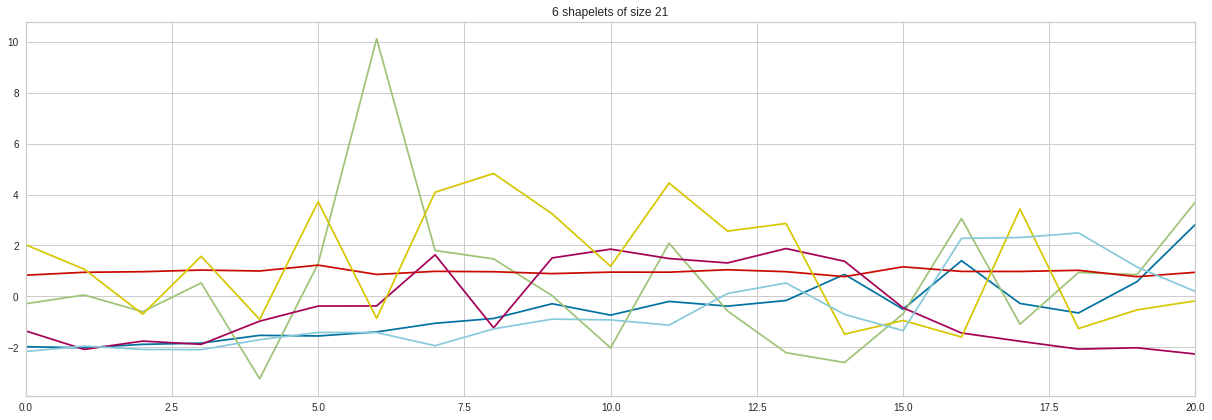

In [ ]:
plt.figure(figsize=(17,6))
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

From the model it is also possible to retrieve the evolution of the cross-entropy loss during the training phase and plot it.

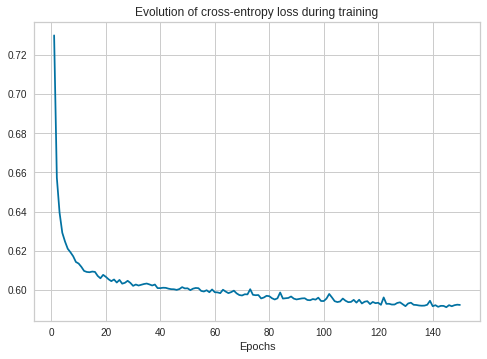

In [ ]:
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

The function 'locate' of LearningShapelet computes shapelet match location for the input time series. With the aid of this function it is possible to plot a time series of the data set, the shapelets extracted by the learner and their best matching location over the time series.

27/27 [==============================] - 1s 44ms/step


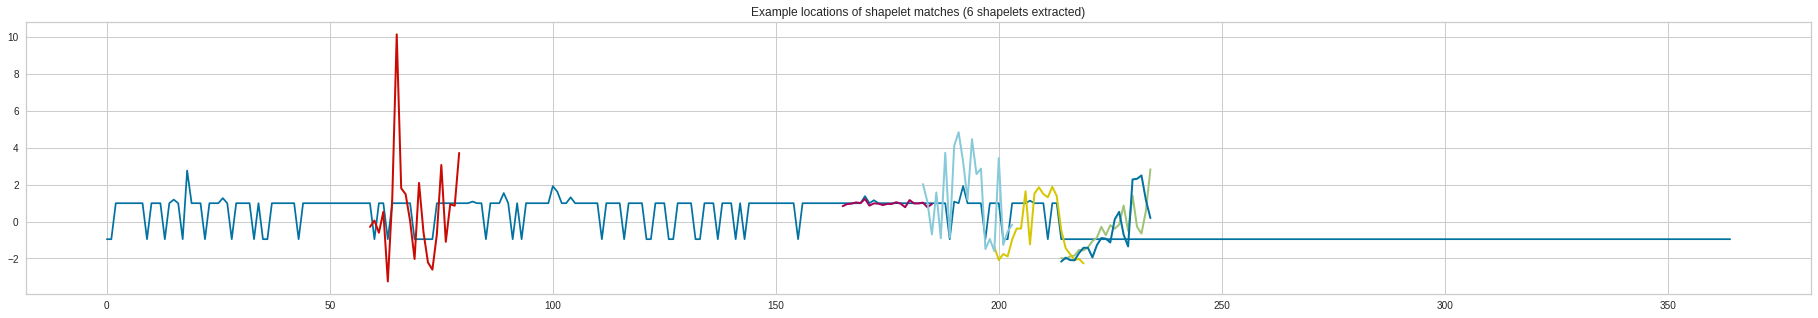

In [ ]:
predicted_locations = shp_clf.locate(X)

ts_id = 543
plt.figure(figsize=(32,5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "({n_shapelets} shapelets extracted)".format(n_shapelets = n_shapelets))

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)